In [1]:
# %%
import os
import csv
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import clone

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report,
    confusion_matrix, roc_auc_score,
    r2_score, mean_absolute_error,
    roc_curve, precision_recall_curve, auc
)
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, VotingClassifier
)

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, StratifiedKFold, cross_validate

# Configuration globale
plt.style.use("ggplot")
sns.set_context("notebook")

RANDOM_STATE = 42
YEARS = [2014, 2015, 2016, 2017, 2018]
DATA_DIR = "."  # adapte si besoin

In [2]:
# %%
def read_csv_robust(path):
    """
    Essaye ',' et ';' et garde celui qui donne le plus de colonnes.
    """
    best_df = None
    best_sep = None
    best_ncols = -1

    for sep in [",", ";"]:
        try:
            df = pd.read_csv(path, sep=sep, engine="python")
            if df.shape[1] > best_ncols:
                best_df = df
                best_sep = sep
                best_ncols = df.shape[1]
        except Exception:
            continue

    if best_df is None:
        raise ValueError(f"Impossible de lire le fichier: {path}")

    return best_df, best_sep


def load_yearly_csvs(years, data_dir="."):
    dfs = []
    for y in years:
        path = os.path.join(data_dir, f"{y}_Financial_Data.csv")
        if not os.path.exists(path):
            raise FileNotFoundError(f"Fichier manquant: {path}")

        df, sep = read_csv_robust(path)
        df["Year"] = y
        print(f"Loaded {os.path.basename(path)} (sep='{sep}') -> shape {df.shape}")
        dfs.append(df)

    data = pd.concat(dfs, ignore_index=True)

    # drop colonnes index parasites courantes
    for c in ["Unnamed: 0", "Unnamed: 0.1"]:
        if c in data.columns:
            data = data.drop(columns=[c])

    print("Final loaded shape:", data.shape)
    return data


def clean_colname(c):
    if not isinstance(c, str):
        return c
    c = c.replace("\ufeff", "")   # BOM éventuel
    c = c.replace('"', "").strip()
    c = " ".join(c.split())       # espaces multiples -> 1
    return c


# %%
# Chargement
data = load_yearly_csvs(YEARS, DATA_DIR)
data.columns = [clean_colname(c) for c in data.columns]

# Drop colonnes "fantômes" si jamais
ghost_cols = [c for c in data.columns if isinstance(c, str) and c.strip().startswith(";")]
if ghost_cols:
    print(f"Dropping {len(ghost_cols)} ghost col(s). Example:", ghost_cols[0])
    data = data.drop(columns=ghost_cols)

print("After cleanup:", data.shape)

# %%
# Création de la Target et Nettoyage initial
price_var_cols = [c for c in data.columns if isinstance(c, str) and "PRICE VAR" in c.upper()]
if not price_var_cols:
    raise ValueError("Aucune colonne 'PRICE VAR' trouvée.")

def target_col_for_year(y: int) -> str:
    return f"{y+1} PRICE VAR [%]"

data2 = data.copy()
data2["Target_Price_Var"] = np.nan

for y in sorted(data2["Year"].unique()):
    col = target_col_for_year(int(y))
    if col in data2.columns:
        mask = data2["Year"] == y
        data2.loc[mask, "Target_Price_Var"] = pd.to_numeric(data2.loc[mask, col], errors="coerce")

print("Target null rate:", data2["Target_Price_Var"].isna().mean())

# anti-leakage: drop toutes les colonnes PRICE VAR originales
data2 = data2.drop(columns=price_var_cols)

# parfois "Class" existe : on le drop
if "Class" in data2.columns:
    data2 = data2.drop(columns=["Class"])

# Filtrage et clipping
data_clean = data2.dropna(subset=["Target_Price_Var"]).copy()

# clip target
data_clean["Target_Price_Var"] = data_clean["Target_Price_Var"].clip(lower=-99, upper=500)

# drop colonnes trop manquantes (>40% NA)
threshold = 0.40
min_non_na = int(len(data_clean) * (1 - threshold))
data_clean = data_clean.dropna(axis=1, thresh=min_non_na)

# target binaire
data_clean["Target_Buy"] = (data_clean["Target_Price_Var"] > 0).astype(int)

# defragment (perf warning)
data_clean = data_clean.copy()

print("Shape clean:", data_clean.shape)
print("Buy rate:", data_clean["Target_Buy"].mean().round(4))

Loaded 2014_Financial_Data.csv (sep=';') -> shape (3808, 227)
Loaded 2015_Financial_Data.csv (sep=';') -> shape (4120, 226)
Loaded 2016_Financial_Data.csv (sep=',') -> shape (4797, 226)
Loaded 2017_Financial_Data.csv (sep=',') -> shape (4960, 226)
Loaded 2018_Financial_Data.csv (sep=',') -> shape (4392, 226)
Final loaded shape: (22077, 231)
After cleanup: (22077, 231)
Target null rate: 0.0
Shape clean: (22077, 218)
Buy rate: 0.5499


=== EXPLORATION APPROFONDIE DES DONNÉES ===
Shape du dataset nettoyé: (22077, 218)
Période: 2014 - 2018
Nombre de features numériques (incluant targets/Year): 216

--- Distribution de la Variable Cible (Target_Price_Var) ---


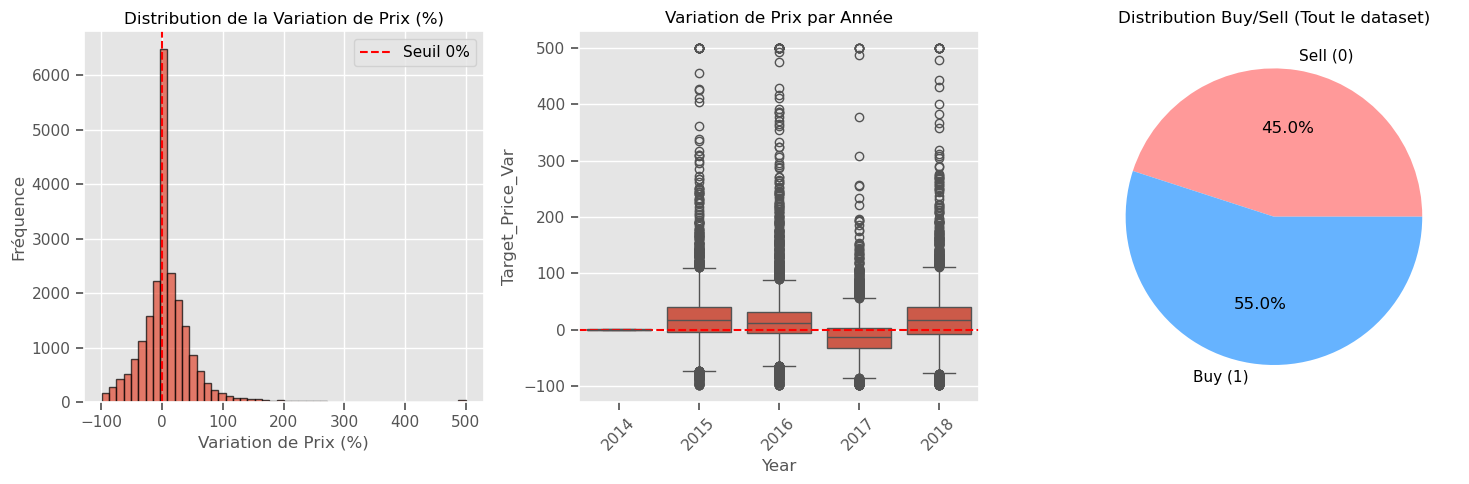


--- Analyse par Secteur (Top secteurs) ---


C:\Users\grego\AppData\Local\Temp\ipykernel_27960\1925154497.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sector_counts_top.values, y=sector_counts_top.index, ax=axes[0], palette="viridis")
C:\Users\grego\AppData\Local\Temp\ipykernel_27960\1925154497.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sector_perf_top.values, y=sector_perf_top.index, ax=axes[1], palette="coolwarm")


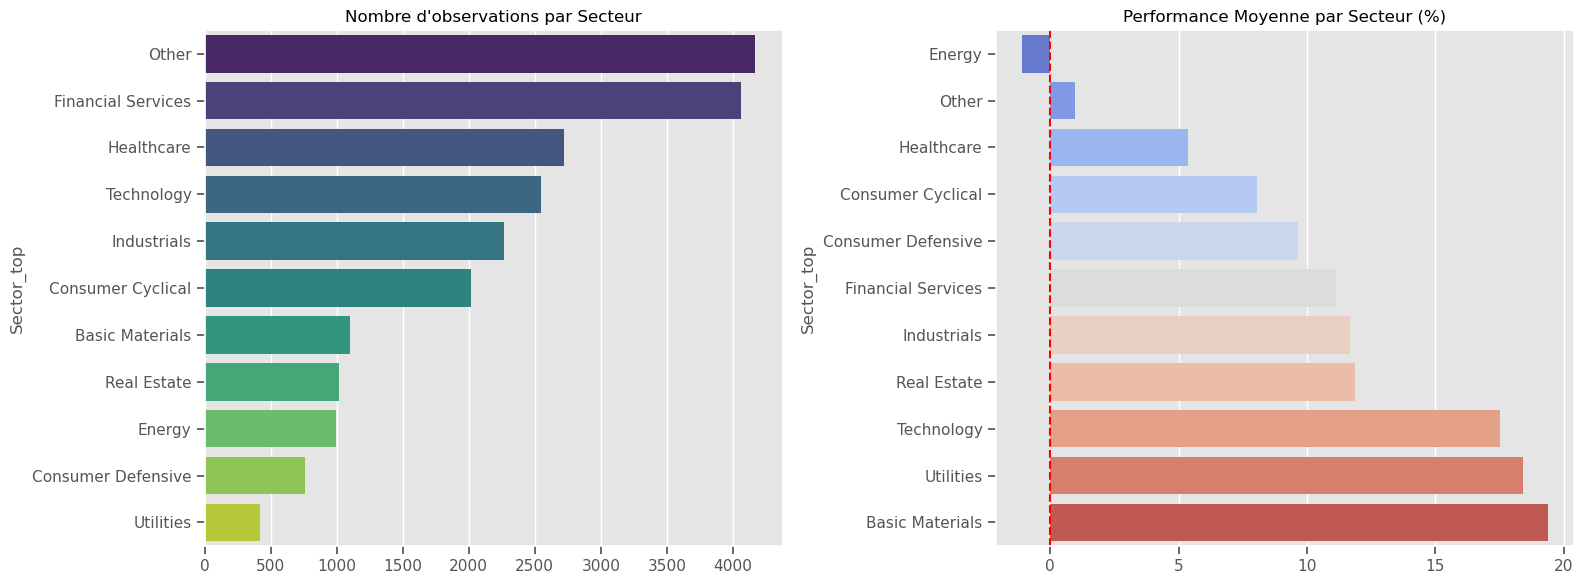


--- Corrélations avec Target_Price_Var (numérique) ---


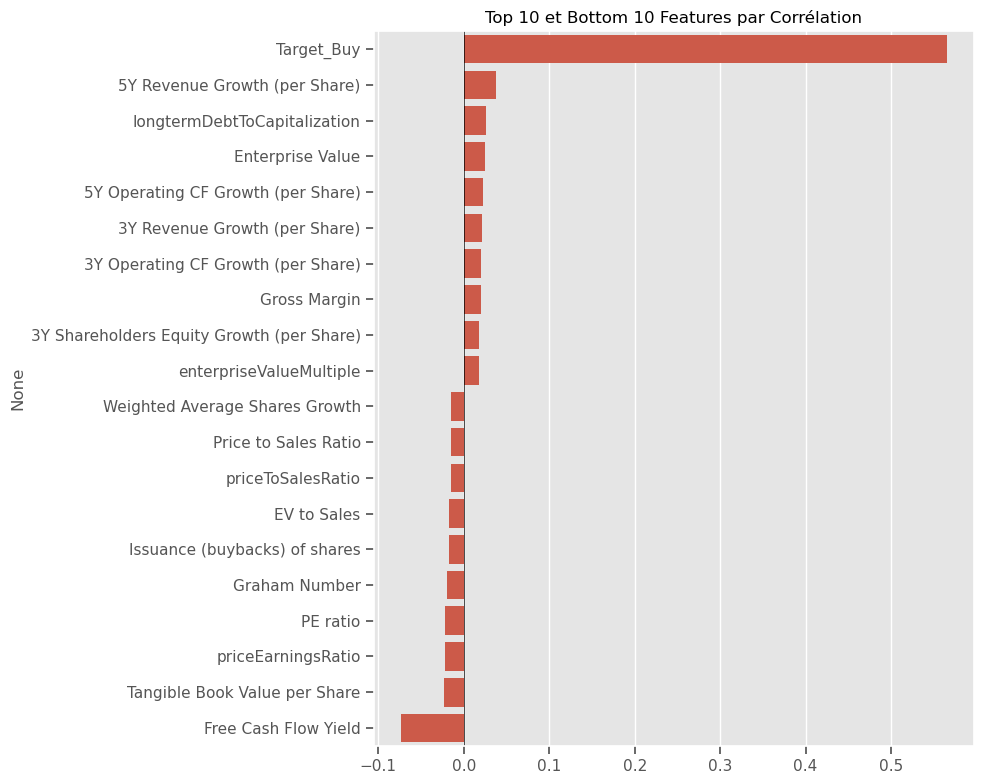

In [3]:
# %%
print("=== EXPLORATION APPROFONDIE DES DONNÉES ===")
print(f"Shape du dataset nettoyé: {data_clean.shape}")
print(f"Période: {data_clean['Year'].min()} - {data_clean['Year'].max()}")

# Colonnes numériques
numeric_cols = data_clean.select_dtypes(include=np.number).columns.tolist()
print(f"Nombre de features numériques (incluant targets/Year): {len(numeric_cols)}")

print("\n--- Distribution de la Variable Cible (Target_Price_Var) ---")

plt.figure(figsize=(15, 5))

# 1) Histogramme Target_Price_Var
plt.subplot(1, 3, 1)
plt.hist(data_clean["Target_Price_Var"].dropna(), bins=50, edgecolor="black", alpha=0.7)
plt.title("Distribution de la Variation de Prix (%)")
plt.xlabel("Variation de Prix (%)")
plt.ylabel("Fréquence")
plt.axvline(x=0, color="red", linestyle="--", label="Seuil 0%")
plt.legend()

# 2) Boxplot par année
plt.subplot(1, 3, 2)
sns.boxplot(x="Year", y="Target_Price_Var", data=data_clean)
plt.title("Variation de Prix par Année")
plt.xticks(rotation=45)
plt.axhline(y=0, color="red", linestyle="--")

# 3) Pie chart Buy/Sell
plt.subplot(1, 3, 3)
binary_target = data_clean["Target_Buy"]
binary_counts = binary_target.value_counts().sort_index()

plt.pie(
    binary_counts.values,
    labels=["Sell (0)", "Buy (1)"],
    autopct="%1.1f%%",
    colors=["#ff9999", "#66b3ff"]
)
plt.title("Distribution Buy/Sell (Tout le dataset)")

plt.tight_layout()
plt.show()

# Analyse par Secteur
if "Sector" in data_clean.columns:
    print("\n--- Analyse par Secteur (Top secteurs) ---")
    df_sec = data_clean.copy()
    df_sec["Sector"] = df_sec["Sector"].astype(str).str.strip()
    df_sec.loc[df_sec["Sector"].isin(["", "nan", "None"]), "Sector"] = np.nan
    df_sec = df_sec.dropna(subset=["Sector"])

    TOP_N = 10
    sector_counts = df_sec["Sector"].value_counts()
    top_sectors = sector_counts.head(TOP_N).index
    df_sec["Sector_top"] = np.where(df_sec["Sector"].isin(top_sectors), df_sec["Sector"], "Other")

    sector_counts_top = df_sec["Sector_top"].value_counts()
    sector_perf_top = df_sec.groupby("Sector_top")["Target_Price_Var"].mean().sort_values()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.barplot(x=sector_counts_top.values, y=sector_counts_top.index, ax=axes[0], palette="viridis")
    axes[0].set_title(f"Nombre d'observations par Secteur")
    sns.barplot(x=sector_perf_top.values, y=sector_perf_top.index, ax=axes[1], palette="coolwarm")
    axes[1].axvline(x=0, color="red", linestyle="--")
    axes[1].set_title(f"Performance Moyenne par Secteur (%)")
    plt.tight_layout()
    plt.show()

# Corrélations
print("\n--- Corrélations avec Target_Price_Var (numérique) ---")
corr_df = data_clean.select_dtypes(include=np.number).copy()
all_nan_cols = [c for c in corr_df.columns if corr_df[c].isna().all()]
if all_nan_cols:
    corr_df = corr_df.drop(columns=all_nan_cols)

correlation_matrix = corr_df.corr(numeric_only=True)

if "Target_Price_Var" in correlation_matrix.columns:
    target_corr = correlation_matrix["Target_Price_Var"].drop(labels=["Target_Price_Var"], errors="ignore").sort_values(ascending=False)
    top_corr = target_corr.head(10)
    bottom_corr = target_corr.tail(10)
    combined_corr = pd.concat([top_corr, bottom_corr])

    plt.figure(figsize=(10, 8))
    sns.barplot(x=combined_corr.values, y=combined_corr.index)
    plt.title("Top 10 et Bottom 10 Features par Corrélation")
    plt.axvline(x=0, color="black", linestyle="-", linewidth=0.5)
    plt.tight_layout()
    plt.show()

Train shape: (17685, 218) | Test shape: (4392, 218)
Train buy rate: 0.5146 | Test buy rate: 0.6919


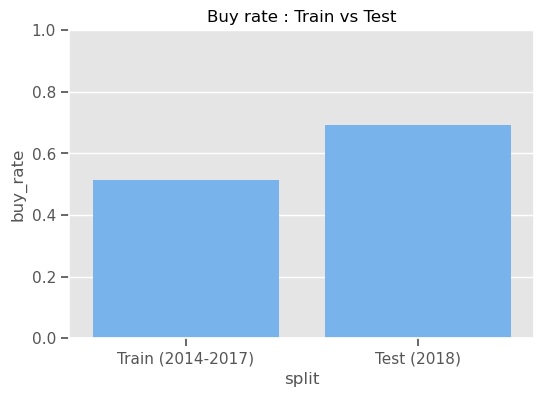

Winsorisation features: done.
RAW features: 213
ENGINEERED features: ['ROE_calc', 'Net_Margin_calc', 'Debt_to_Equity_calc', 'EPS', 'EBITDA', 'Operating Cash Flow', 'Market Cap']


In [4]:
# %%
# Split Temporel
train_df = data_clean[data_clean["Year"].isin([2014, 2015, 2016, 2017])].copy()
test_df  = data_clean[data_clean["Year"] == 2018].copy()

y_train = train_df["Target_Buy"].values
y_test  = test_df["Target_Buy"].values

print("Train shape:", train_df.shape, "| Test shape:", test_df.shape)
print("Train buy rate:", y_train.mean().round(4), "| Test buy rate:", y_test.mean().round(4))

# Check visuel split
rates = pd.DataFrame({
    "split": ["Train (2014-2017)", "Test (2018)"],
    "buy_rate": [float(np.mean(y_train)), float(np.mean(y_test))]
})
plt.figure(figsize=(6, 4))
sns.barplot(data=rates, x="split", y="buy_rate", color="#66b3ff")
plt.ylim(0, 1)
plt.title("Buy rate : Train vs Test")
plt.show()

# Winsorisation (Outlier Clipping)
num_cols = [c for c in train_df.select_dtypes(include=np.number).columns
            if c not in ["Year", "Target_Price_Var", "Target_Buy"]]

q_low = train_df[num_cols].quantile(0.01)
q_high = train_df[num_cols].quantile(0.99)

train_df[num_cols] = train_df[num_cols].clip(q_low, q_high, axis=1)
test_df[num_cols]  = test_df[num_cols].clip(q_low, q_high, axis=1)
print("Winsorisation features: done.")

# 1. Dataset RAW (Features brutes)
raw_feature_cols = train_df.select_dtypes(include=np.number).columns.tolist()
raw_feature_cols = [c for c in raw_feature_cols if c not in ["Year", "Target_Price_Var", "Target_Buy"]]

X_train_raw = train_df[raw_feature_cols].copy()
X_test_raw  = test_df[raw_feature_cols].copy()
print("RAW features:", len(raw_feature_cols))

# 2. Dataset ENGINEERED (Ratios)
def add_financial_ratios(df: pd.DataFrame):
    out = df.copy()
    # Equity
    possible_equity_cols = ["Total shareholders equity", "Shareholders Equity", "Total Stockholders Equity"]
    equity_col = next((c for c in possible_equity_cols if c in out.columns), None)
    if equity_col is None:
        # Fallback calc
        assets_col = "Total assets" if "Total assets" in out.columns else "Total Assets"
        liab_col = "Total liabilities" if "Total liabilities" in out.columns else "Total Liabilities"
        out["Calc_Equity"] = pd.to_numeric(out.get(assets_col, np.nan), errors="coerce") - pd.to_numeric(out.get(liab_col, np.nan), errors="coerce")
        equity_col = "Calc_Equity"

    # Debt
    possible_debt_cols = ["Total Debt", "Total debt", "Long-term debt", "Net Debt"]
    debt_col = next((c for c in possible_debt_cols if c in out.columns), None)

    eps = 1e-6
    net_income = pd.to_numeric(out.get("Net Income", np.nan), errors="coerce")
    revenue    = pd.to_numeric(out.get("Revenue", np.nan), errors="coerce")
    equity     = pd.to_numeric(out.get(equity_col, np.nan), errors="coerce")
    debt       = pd.to_numeric(out.get(debt_col, np.nan), errors="coerce") if debt_col else np.nan

    out["ROE_calc"] = net_income / (equity + eps)
    out["Net_Margin_calc"] = net_income / (revenue + eps)
    out["Debt_to_Equity_calc"] = debt / (equity + eps)
    return out, {"equity_col": equity_col, "debt_col": debt_col}

train_eng, meta_train = add_financial_ratios(train_df)
test_eng,  meta_test  = add_financial_ratios(test_df)

desired_features = ["ROE_calc", "Net_Margin_calc", "Debt_to_Equity_calc", "EPS", "EBITDA", "Operating Cash Flow", "Market Cap"]
engineered_cols = [c for c in desired_features if c in train_eng.columns and c in test_eng.columns]

X_train_eng = train_eng[engineered_cols].copy()
X_test_eng  = test_eng[engineered_cols].copy()
print("ENGINEERED features:", engineered_cols)

In [5]:
# %%
def eval_classifier(model, X_train, y_train, X_test, y_test, name="model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    bacc = balanced_accuracy_score(y_test, preds)

    print(f"\n=== {name} ===")
    print(f"Accuracy:          {acc:.4f}")
    print(f"Balanced Accuracy: {bacc:.4f}")

    auc_score = None
    if proba is not None:
        auc_score = roc_auc_score(y_test, proba)
        print(f"ROC-AUC:           {auc_score:.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, preds, digits=4))

    return {
        "model": name,
        "acc": acc,
        "bacc": bacc,
        "auc": auc_score
    }

Linear Regression Results:
R2 Score: -0.0613
Mean Absolute Error (MAE): 37.07%

=== RAW-LogReg ===
Accuracy:          0.6651
Balanced Accuracy: 0.6134
ROC-AUC:           0.6593

Classification report:
              precision    recall  f1-score   support

           0     0.4583    0.4789    0.4684      1353
           1     0.7633    0.7479    0.7555      3039

    accuracy                         0.6651      4392
   macro avg     0.6108    0.6134    0.6120      4392
weighted avg     0.6693    0.6651    0.6671      4392


=== RAW-RF ===
Accuracy:          0.6551
Balanced Accuracy: 0.6296
ROC-AUC:           0.6892

Classification report:
              precision    recall  f1-score   support

           0     0.4520    0.5632    0.5015      1353
           1     0.7816    0.6960    0.7363      3039

    accuracy                         0.6551      4392
   macro avg     0.6168    0.6296    0.6189      4392
weighted avg     0.6800    0.6551    0.6640      4392


=== RAW-GradBoost ===
Accu

c:\Users\grego\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\grego\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\grego\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\grego\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\grego\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e


=== RAW-HistGB ===
Accuracy:          0.6494
Balanced Accuracy: 0.6230
ROC-AUC:           0.6776

Classification report:
              precision    recall  f1-score   support

           0     0.4446    0.5543    0.4934      1353
           1     0.7771    0.6917    0.7319      3039

    accuracy                         0.6494      4392
   macro avg     0.6108    0.6230    0.6127      4392
weighted avg     0.6746    0.6494    0.6584      4392



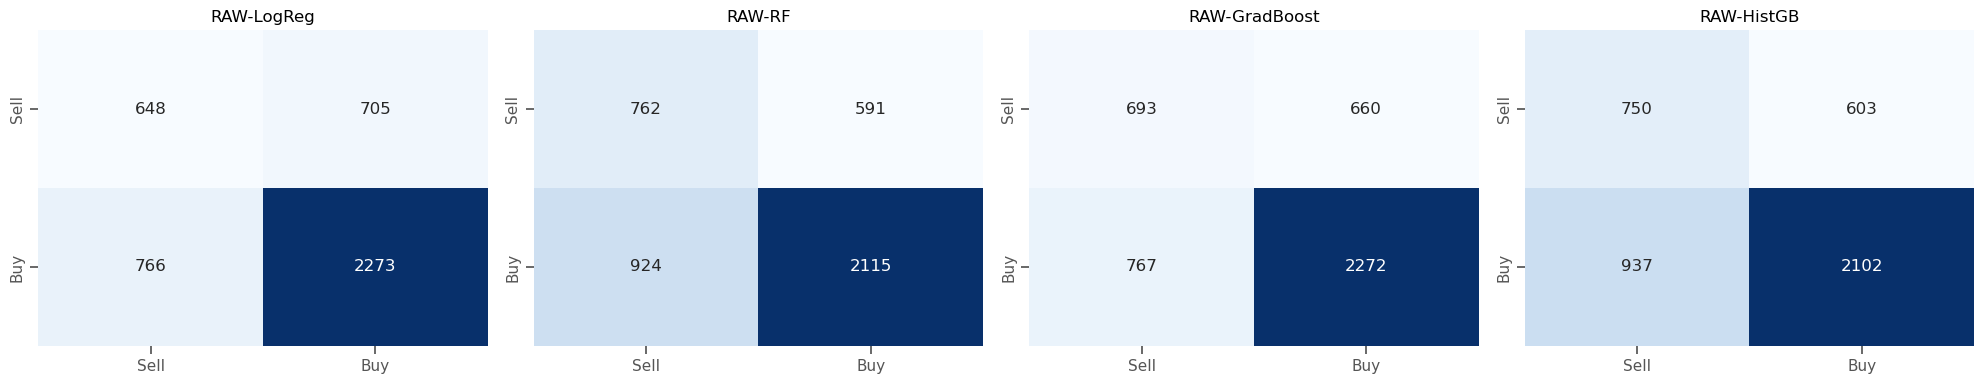

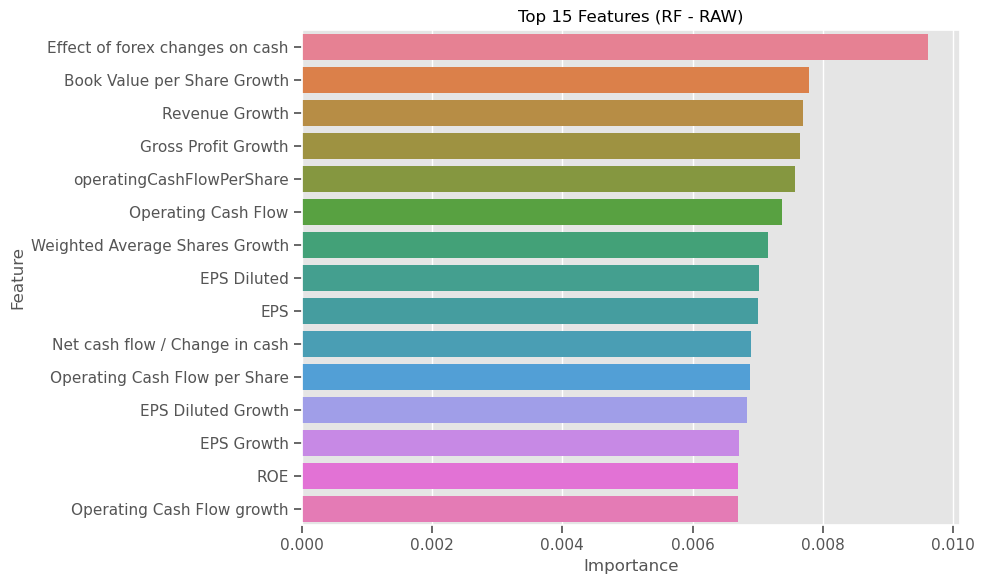


=== PCA95-LogReg ===
Accuracy:          0.6628
Balanced Accuracy: 0.6097
ROC-AUC:           0.6659

Classification report:
              precision    recall  f1-score   support

           0     0.4544    0.4715    0.4628      1353
           1     0.7607    0.7479    0.7543      3039

    accuracy                         0.6628      4392
   macro avg     0.6076    0.6097    0.6085      4392
weighted avg     0.6664    0.6628    0.6645      4392


=== PCA95-RF ===
Accuracy:          0.6416
Balanced Accuracy: 0.6121
ROC-AUC:           0.6656

Classification report:
              precision    recall  f1-score   support

           0     0.4338    0.5351    0.4792      1353
           1     0.7690    0.6890    0.7268      3039

    accuracy                         0.6416      4392
   macro avg     0.6014    0.6121    0.6030      4392
weighted avg     0.6657    0.6416    0.6505      4392


=== ENG-LogReg ===
Accuracy:          0.6719
Balanced Accuracy: 0.6452
ROC-AUC:           0.6800

Cla

In [6]:
# %%
# 1. Baseline Régression Linéaire (Target continue)
y_train_reg = train_df["Target_Price_Var"].values
y_test_reg  = test_df["Target_Price_Var"].values

reg_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression()),
])
reg_pipeline.fit(X_train_raw, y_train_reg)
preds_reg = reg_pipeline.predict(X_test_raw)
print("Linear Regression Results:")
print(f"R2 Score: {r2_score(y_test_reg, preds_reg):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_reg, preds_reg):.2f}%")

# 2. Screening Modèles sur RAW Data
raw_models = {
    "RAW-LogReg": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "RAW-RF": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1))
    ]),
    "RAW-GradBoost": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
    "RAW-HistGB": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
}

results = []
for name, model in raw_models.items():
    results.append(eval_classifier(model, X_train_raw, y_train, X_test_raw, y_test, name=name))

# Matrice de confusion RAW
fig, axes = plt.subplots(1, len(raw_models), figsize=(5 * len(raw_models), 4))
if len(raw_models) == 1: axes = [axes]
for ax, (name, model) in zip(axes, raw_models.items()):
    preds = model.predict(X_test_raw)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                xticklabels=["Sell", "Buy"], yticklabels=["Sell", "Buy"])
    ax.set_title(name)
plt.tight_layout()
plt.show()

# Importance des features (RF RAW)
rf_for_importance = raw_models["RAW-RF"]
rf_step = rf_for_importance.named_steps["clf"]
importances = rf_step.feature_importances_
df_imp = pd.DataFrame({"Feature": raw_feature_cols, "Importance": importances}).sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x="Importance", y="Feature", hue="Feature", dodge=False, legend=False)
plt.title("Top 15 Features (RF - RAW)")
plt.tight_layout()
plt.show()

# 3. Modèles avec PCA
pca_models = {
    "PCA95-LogReg": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE)),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "PCA95-RF": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95, random_state=RANDOM_STATE)),
        ("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1))
    ])
}
pca_results = []
for name, model in pca_models.items():
    pca_results.append(eval_classifier(model, X_train_raw, y_train, X_test_raw, y_test, name=name))

# 4. Modèles sur Engineered Features
eng_models = {
    "ENG-LogReg": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE))
    ]),
    "ENG-RF": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1))
    ]),
    "ENG-GradBoost": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
}
eng_results = []
for name, model in eng_models.items():
    eng_results.append(eval_classifier(model, X_train_eng, y_train, X_test_eng, y_test, name=name))

In [ ]:
# %%
param_dist = {
    "clf__n_estimators": [100, 200, 300, 500],
    "clf__max_depth": [10, 20, None],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__class_weight": ["balanced", "balanced_subsample"]
}

tuning_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

# A) Tuning CV Classique
search_classic = RandomizedSearchCV(
    tuning_pipeline, param_distributions=param_dist, n_iter=10, cv=3,
    scoring="accuracy", n_jobs=-1, random_state=RANDOM_STATE
)
search_classic.fit(X_train_raw, y_train)
best_rf_classic = search_classic.best_estimator_
classic_res = eval_classifier(best_rf_classic, X_train_raw, y_train, X_test_raw, y_test, name="TUNED-RF-classicCV")

# B) Tuning TimeSeriesSplit
# (nécessite data triée par année, c'est le cas par défaut mais on force le tri)
train_only = train_df.sort_values("Year").copy()
X_tv = train_only[raw_feature_cols].copy()
y_tv = train_only["Target_Buy"].values
tscv = TimeSeriesSplit(n_splits=3)

search_time = RandomizedSearchCV(
    tuning_pipeline, param_distributions=param_dist, n_iter=15, cv=tscv,
    scoring="roc_auc", n_jobs=-1, random_state=RANDOM_STATE
)
search_time.fit(X_tv, y_tv)
best_rf_time = search_time.best_estimator_
time_res = eval_classifier(best_rf_time, X_train_raw, y_train, X_test_raw, y_test, name="TUNED-RF-TimeSeriesSplit")

# C) Voting Classifier (Soft)
voting = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE)),
        ("rf", RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1)),
        ("hgb", HistGradientBoostingClassifier(random_state=RANDOM_STATE)),
    ],
    voting="soft"
)
voting_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", voting)
])
voting_res = eval_classifier(voting_pipe, X_train_raw, y_train, X_test_raw, y_test, name="RAW-Voting(soft)")

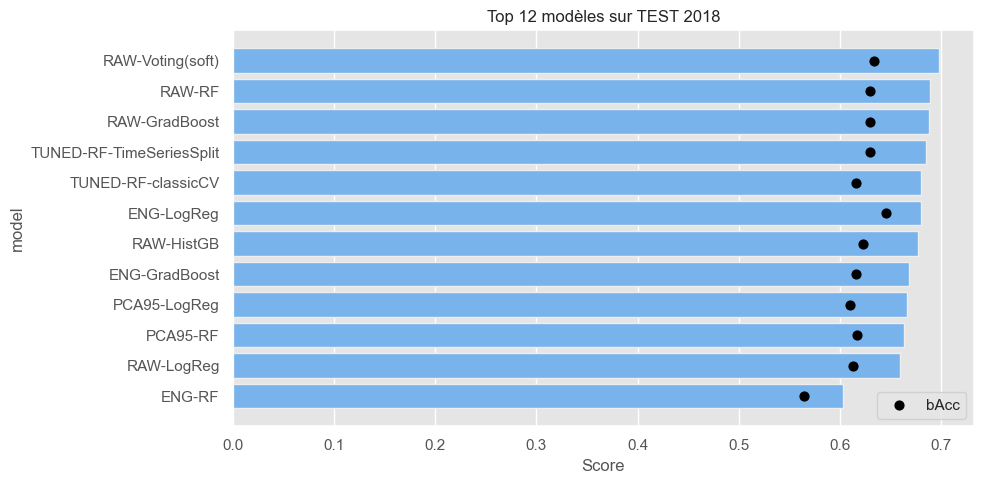

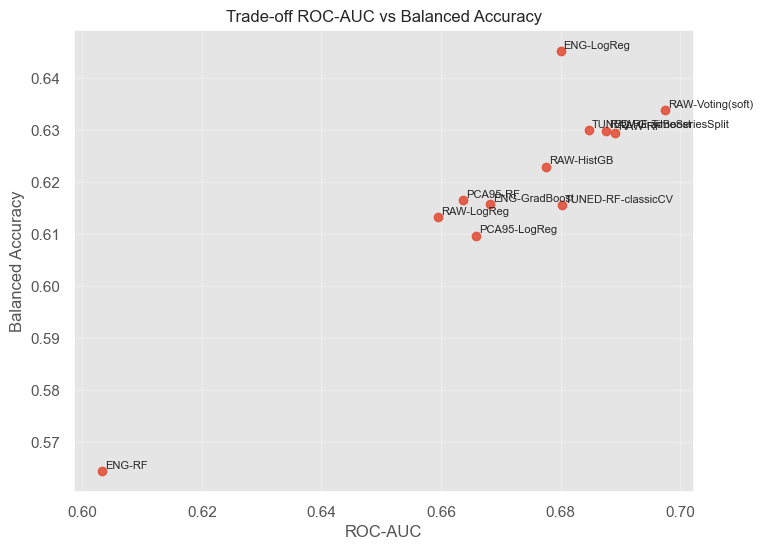

,model,acc,bacc,auc
11,RAW-Voting(soft),0.670310,0.633830,0.697540
1,RAW-RF,0.655055,0.629573,0.689172
2,RAW-GradBoost,0.675091,0.629905,0.687635
10,TUNED-RF-TimeSeriesSplit,0.658242,0.630031,0.684697
9,TUNED-RF-classicCV,0.642760,0.615563,0.680217
6,ENG-LogReg,0.671903,0.645233,0.680002
3,RAW-HistGB,0.649362,0.622999,0.677568
8,ENG-GradBoost,0.684199,0.615779,0.668152
4,PCA95-LogReg,0.662796,0.609744,0.665908
5,PCA95-RF,0.650956,0.616565,0.663651


In [ ]:
# %%
all_results = []
all_results.extend(results)       # RAW baselines
all_results.extend(pca_results)   # PCA
all_results.extend(eng_results)   # ENG
all_results.append(classic_res)   # tuned classic
all_results.append(time_res)      # tuned time series
all_results.append(voting_res)    # voting

final_df = pd.DataFrame(all_results)
final_df["auc"] = final_df["auc"].astype(float)
final_df = final_df.sort_values(by=["auc", "bacc"], ascending=False)

# Affichage Leaderboard Visuel
lb = final_df.copy()
TOP_K = min(12, len(lb))
lbk = lb.head(TOP_K).copy()

plt.figure(figsize=(10, 5))
sns.barplot(data=lbk, y="model", x="auc", color="#66b3ff")
plt.scatter(lbk["bacc"], lbk["model"], color="black", s=40, label="bAcc", zorder=3)
plt.title(f"Top {TOP_K} modèles sur TEST 2018")
plt.xlabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

# Scatter AUC vs bAcc
plt.figure(figsize=(8, 6))
plt.scatter(final_df["auc"], final_df["bacc"], alpha=0.85)
for _, r in final_df.iterrows():
    plt.text(r["auc"] + 0.0005, r["bacc"] + 0.0005, r["model"], fontsize=8)
plt.title("Trade-off ROC-AUC vs Balanced Accuracy")
plt.xlabel("ROC-AUC")
plt.ylabel("Balanced Accuracy")
plt.grid(True, alpha=0.3)
plt.show()

display(final_df)

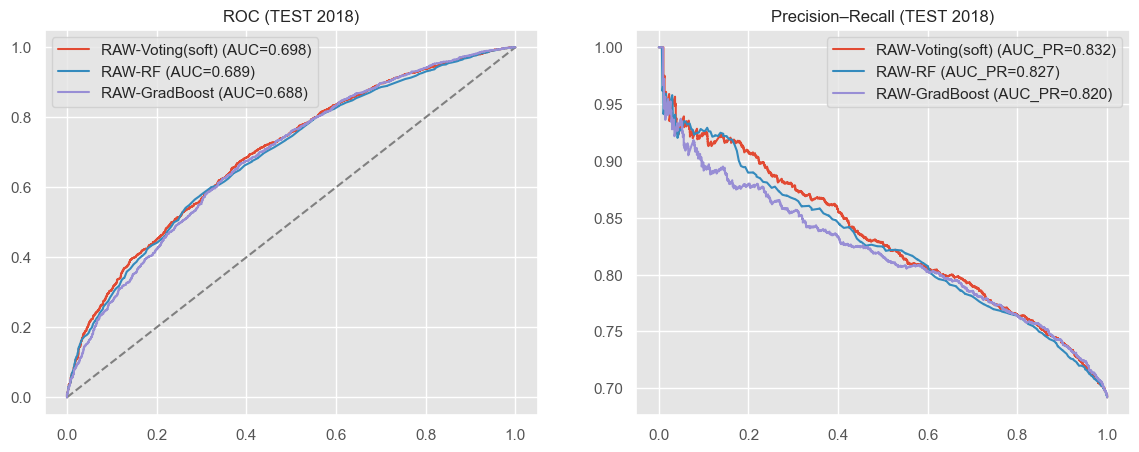

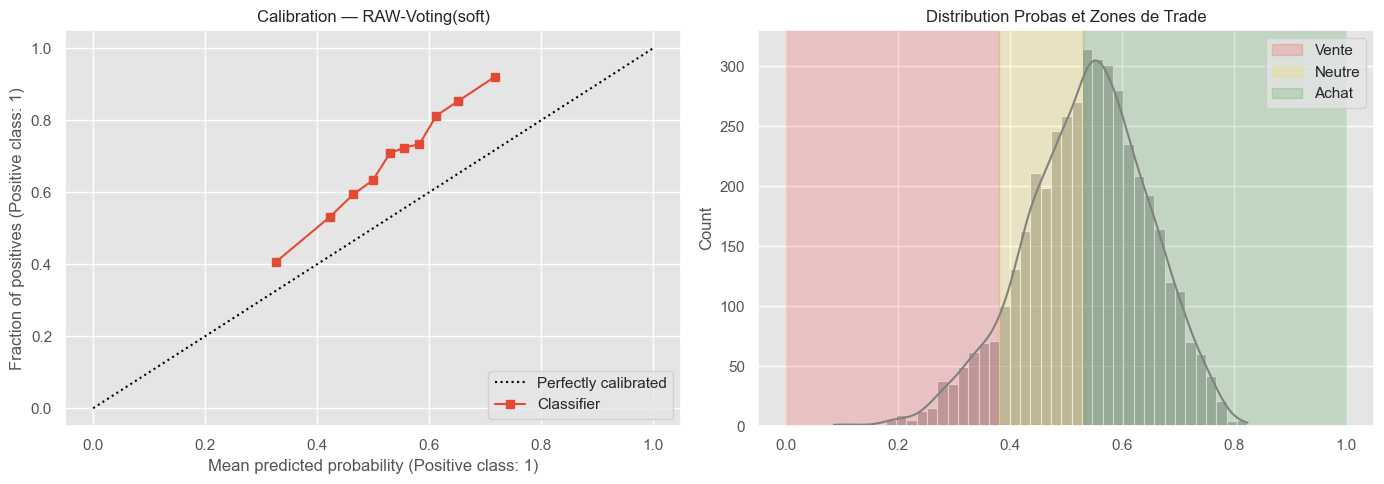

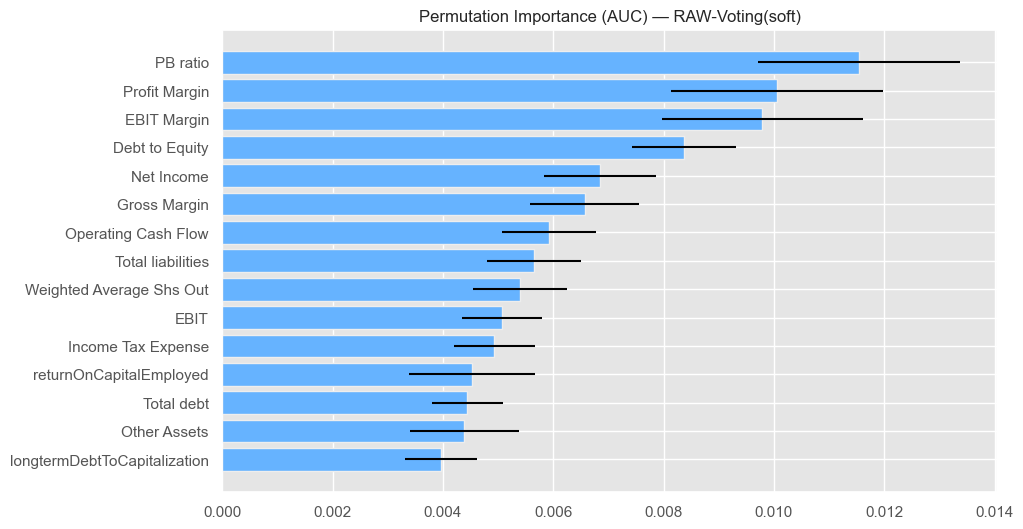

In [ ]:
# %%
# Sélection des candidats pour les courbes
CANDIDATES = {
    "RAW-Voting(soft)": voting_pipe,
    "RAW-RF": raw_models["RAW-RF"],
    "RAW-GradBoost": raw_models["RAW-GradBoost"],
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].set_title("ROC (TEST 2018)")
axes[1].set_title("Precision–Recall (TEST 2018)")

for name, model in CANDIDATES.items():
    model.fit(X_train_raw, y_train)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test_raw)[:, 1]
        # ROC
        fpr, tpr, _ = roc_curve(y_test, proba)
        axes[0].plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.3f})")
        # PR
        prec, rec, _ = precision_recall_curve(y_test, proba)
        axes[1].plot(rec, prec, label=f"{name} (AUC_PR={auc(rec, prec):.3f})")

axes[0].legend()
axes[1].legend()
plt.show()

# --- CALIBRATION & ZONES ---
BEST_NAME = "RAW-Voting(soft)"
BEST_MODEL = voting_pipe
BEST_MODEL.fit(X_train_raw, y_train)
proba = BEST_MODEL.predict_proba(X_test_raw)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Calibration
CalibrationDisplay.from_predictions(y_true=y_test, y_prob=proba, n_bins=10, strategy="quantile", ax=axes[0])
axes[0].set_title(f"Calibration — {BEST_NAME}")

# Histogramme Probas + Zones
SEUIL_BAS, SEUIL_HAUT = 0.38, 0.53
sns.histplot(proba, bins=40, kde=True, ax=axes[1], color="gray")
axes[1].axvspan(0, SEUIL_BAS, color="red", alpha=0.15, label="Vente")
axes[1].axvspan(SEUIL_BAS, SEUIL_HAUT, color="gold", alpha=0.15, label="Neutre")
axes[1].axvspan(SEUIL_HAUT, 1, color="green", alpha=0.15, label="Achat")
axes[1].set_title("Distribution Probas et Zones de Trade")
axes[1].legend()
plt.tight_layout()
plt.show()

# --- PERMUTATION IMPORTANCE ---
perm = permutation_importance(BEST_MODEL, X_test_raw, y_test, scoring="roc_auc", n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
imp = pd.DataFrame({
    "feature": raw_feature_cols,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

plt.figure(figsize=(10, 6))
top = imp.head(15).iloc[::-1]
plt.barh(top["feature"], top["importance_mean"], xerr=top["importance_std"], color="#66b3ff")
plt.title(f"Permutation Importance (AUC) — {BEST_NAME}")
plt.show()

In [ ]:
# %%
# A) Cross-Validation TimeSeriesSplit sur Modèles RAW
train_sorted = train_df.sort_values(["Year"]).reset_index(drop=True)
X_tv_raw = train_sorted[raw_feature_cols].copy()
y_tv = train_sorted["Target_Buy"].values

MODELS_CV = {
    "LogReg": Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("clf", LogisticRegression(class_weight="balanced", max_iter=2000))]),
    "RF": Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced", n_jobs=-1))]),
    "GB": Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("clf", GradientBoostingClassifier())]),
}

cv_rows = []
for name, pipe in MODELS_CV.items():
    scores = cross_validate(pipe, X_tv_raw, y_tv, cv=TimeSeriesSplit(n_splits=3), scoring={"auc":"roc_auc", "bacc":"balanced_accuracy"}, n_jobs=-1, return_train_score=True)
    cv_rows.append({
        "model": f"RAW-{name}",
        "auc_cv_mean": scores["test_auc"].mean(),
        "auc_overfit": scores["train_auc"].mean() - scores["test_auc"].mean()
    })
print("--- TimeSeriesSplit Results ---")
display(pd.DataFrame(cv_rows).sort_values("auc_cv_mean", ascending=False))

# B) Cross-Validation INTRA-ANNÉE (StratifiedKFold)
print("\n--- Intra-Year Stratified CV ---")
X_train_raw_cv = X_train_raw.copy()
X_train_eng_cv = X_train_eng.copy()
y_train_cv = pd.Series(y_train, index=X_train_raw_cv.index)
years_train = train_df.loc[X_train_raw_cv.index, "Year"].astype(int)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rows_intra = []

# On réutilise les définitions modèles (RAW vs ENG)
def run_year_cv(features_type, X_data, models_dict):
    for year in sorted(years_train.unique()):
        mask = (years_train == year)
        Xy = X_data.loc[mask]
        yy = y_train_cv.loc[mask]
        if min(yy.value_counts()) < 5: continue # skip if too few samples

        for m_name, model in models_dict.items():
            for fold, (tr_idx, val_idx) in enumerate(skf.split(Xy, yy)):
                m = clone(model)
                m.fit(Xy.iloc[tr_idx], yy.iloc[tr_idx])
                pred = m.predict(Xy.iloc[val_idx])
                proba = m.predict_proba(Xy.iloc[val_idx])[:, 1] if hasattr(m, "predict_proba") else None
                rows_intra.append({
                    "year": int(year), "features": features_type, "model": m_name, "fold": fold,
                    "acc": accuracy_score(yy.iloc[val_idx], pred),
                    "auc": roc_auc_score(yy.iloc[val_idx], proba) if proba is not None else np.nan
                })

# Lancer sur RAW et ENG (Note: simplifie en utilisant les dicts définis plus haut)
# On reconstruit les dictionnaires pour être sûr des définitions propres à ce bloc
MODELS_RAW_CV = {k: v for k, v in raw_models.items()} 
MODELS_ENG_CV = {k: v for k, v in eng_models.items()}

run_year_cv("raw", X_train_raw_cv, MODELS_RAW_CV)
run_year_cv("eng", X_train_eng_cv, MODELS_ENG_CV)

cv_intra_df = pd.DataFrame(rows_intra)
summary_global = cv_intra_df.groupby(["features", "model"]).agg(auc_mean=("auc", "mean"), n_folds=("fold", "count")).reset_index().sort_values("auc_mean", ascending=False)
display(summary_global.head())

# Test Final basé sur le meilleur modèle CV Intra-Year
best_row = summary_global.iloc[0]
print(f"Best Intra-Year Model: {best_row['model']} ({best_row['features']})")
# (Logique d'entraînement final déjà couverte par le leaderboard, mais validée ici par stabilité annuelle)

--- TimeSeriesSplit Results ---


,model,auc_cv_mean,auc_overfit
2,RAW-GB,0.564842,0.273539
1,RAW-RF,0.562319,0.436817
0,RAW-LogReg,0.543071,0.185887



--- Intra-Year Stratified CV ---


c:\ESILV\A4\Machine_Learning_A4\Projet V2\ML-Project-FinancialStocks\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Property, Plant & Equipment Net']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\ESILV\A4\Machine_Learning_A4\Projet V2\ML-Project-FinancialStocks\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Property, Plant & Equipment Net']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\ESILV\A4\Machine_Learning_A4\Projet V2\ML-Project-FinancialStocks\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Property, Plant & Equipment Net']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\ESILV\A4\Machine_Learning_A4\Projet V2\ML-Project

,features,model,auc_mean,n_folds
6,raw,RAW-RF,0.713811,20
4,raw,RAW-HistGB,0.704910,20
3,raw,RAW-GradBoost,0.701240,20
5,raw,RAW-LogReg,0.651065,20
0,eng,ENG-GradBoost,0.642242,20


Best Intra-Year Model: RAW-RF (raw)


--- 🚀 Deep Learning (Seed 42) ---
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

=== DEEP LEARNING RESULTATS (Test 2018) ===
AUC: 0.6712921719542961
Acc @0.5: 0.6238615664845173
Acc Active (Trade Rate 48.0%): 0.761972498814604


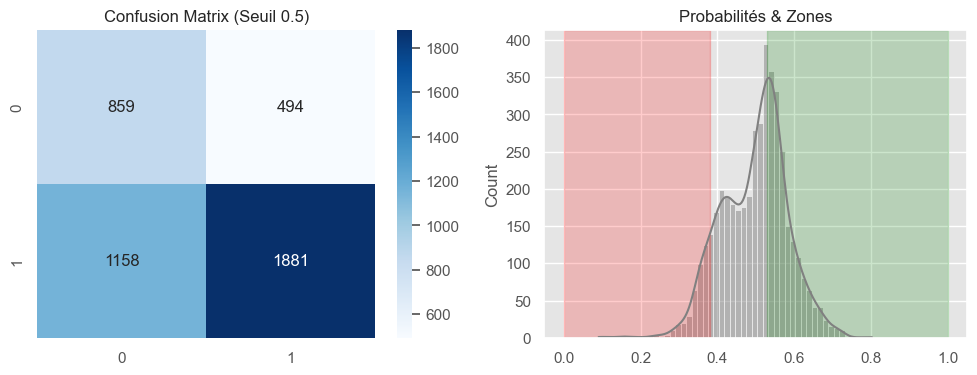

In [ ]:
# %%
import os, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import QuantileTransformer

# SEED LOCK
SEED_VALUE = 42
os.environ["PYTHONHASHSEED"] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

print(f"--- 🚀 Deep Learning (Seed {SEED_VALUE}) ---")

# Data Setup
Xtr_df = X_train_eng.copy()
Xte_df = X_test_eng.copy()
ytr = np.array(y_train).astype(int).ravel()
yte = np.array(y_test).astype(int).ravel()

# Validation Split (Derniers 20% du train)
cut = int(len(Xtr_df) * 0.8)
X_tr_df, X_val_df = Xtr_df.iloc[:cut], Xtr_df.iloc[cut:]
y_tr, y_val = ytr[:cut], ytr[cut:]

# Preprocessing DL Spécifique
imputer = SimpleImputer(strategy="median")
X_tr_i  = imputer.fit_transform(X_tr_df)
X_val_i = imputer.transform(X_val_df)
X_te_i  = imputer.transform(Xte_df)

scaler_nn = QuantileTransformer(output_distribution="normal", n_quantiles=1000, random_state=SEED_VALUE)
X_tr_nn  = scaler_nn.fit_transform(X_tr_i)
X_val_nn = scaler_nn.transform(X_val_i)
X_te_nn  = scaler_nn.transform(X_te_i)

# Modèle
def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128), BatchNormalization(), LeakyReLU(negative_slope=0.1), Dropout(0.4),
        Dense(64),  BatchNormalization(), LeakyReLU(negative_slope=0.1), Dropout(0.3),
        Dense(32),  LeakyReLU(negative_slope=0.1),
        Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])
    return model

model_nn = build_model(X_tr_nn.shape[1])
history = model_nn.fit(
    X_tr_nn, y_tr, validation_data=(X_val_nn, y_val),
    epochs=150, batch_size=64, class_weight={0: 1.5, 1: 1.0},
    callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
    verbose=0
)

# Eval DL
preds_probs = model_nn.predict(X_te_nn).ravel()
preds_std = (preds_probs > 0.5).astype(int)

# Seuils Calibration
mask_active = (preds_probs < 0.38) | (preds_probs > 0.53)
y_active = yte[mask_active]
preds_active = (preds_probs[mask_active] > 0.53).astype(int)

print("\n=== DEEP LEARNING RESULTATS (Test 2018) ===")
print("AUC:", roc_auc_score(yte, preds_probs))
print("Acc @0.5:", accuracy_score(yte, preds_std))
if len(y_active) > 0:
    print(f"Acc Active (Trade Rate {mask_active.mean():.1%}):", accuracy_score(y_active, preds_active))

# Plot DL Results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(confusion_matrix(yte, preds_std), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix (Seuil 0.5)")
sns.histplot(preds_probs, bins=50, kde=True, ax=axes[1], color="gray")
axes[1].axvspan(0, 0.38, color="red", alpha=0.2)
axes[1].axvspan(0.53, 1, color="green", alpha=0.2)
axes[1].set_title("Probabilités & Zones")
plt.show()